In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import random
import numpy as np
import tensorflow as tf
import tifffile
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.18.0


In [19]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tifffile

# --- Configuration and Hyperparameters ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
DATA_PATH = '/kaggle/input/lgg-mri-segmentation/kaggle_3m/'
RANDOM_STATE = 42

# --- Load File Paths ---
all_files = []
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        # We ensure the file is a .tif image and not a mask.
        if filename.endswith('.tif') and '_mask' not in filename:
            all_files.append((os.path.join(dirname, filename),
                              os.path.join(dirname, filename.replace('.tif', '_mask.tif'))))

# --- 80% train, 10% validation, 10% test ---
train_files, temp_files = train_test_split(all_files, test_size=0.2, random_state=RANDOM_STATE)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=RANDOM_STATE)


print(f"Total images found: {len(all_files)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")
print(f"Testing images: {len(test_files)}")


# --- Data Loading and Preprocessing Functions ---
def load_and_preprocess(image_path_tensor, mask_path_tensor):
    image_path = image_path_tensor.numpy().decode('utf-8')
    mask_path = mask_path_tensor.numpy().decode('utf-8')
    
    image = tifffile.imread(image_path)
    mask = tifffile.imread(mask_path)
    
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)
        
    return image.astype(np.float32), mask.astype(np.float32)

@tf.function
def tf_wrapper(image_path, mask_path):
    image, mask = tf.py_function(load_and_preprocess,
                                 [image_path, mask_path],
                                 [tf.float32, tf.float32])
    
    image.set_shape([None, None, IMG_CHANNELS])
    mask.set_shape([None, None, 1])

    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    
    image = image / 255.0
    mask = mask > 0.5
    
    return image, mask

def create_tf_dataset(files, batch_size, shuffle=True):
    image_paths, mask_paths = zip(*files)
    
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(mask_paths)))
    dataset = dataset.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(files), seed=RANDOM_STATE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

# --- Create the three datasets ---
BATCH_SIZE = 32
train_dataset = create_tf_dataset(train_files, BATCH_SIZE)
val_dataset = create_tf_dataset(val_files, BATCH_SIZE)
test_dataset = create_tf_dataset(test_files, BATCH_SIZE, shuffle=False)

print("\nDatasets created successfully!")

Total images found: 3929
Training images: 3143
Validation images: 393
Testing images: 393

Datasets created successfully!


In [20]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    # --- Encoder (Downsampling Path) ---
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # --- Bottleneck ---
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # --- Decoder (Upsampling Path) ---
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4]) # Skip connection
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3]) # Skip connection
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(u7)
    u8 = concatenate([u8, c2]) # Skip connection
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3) # Skip connection
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # --- Output Layer ---
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --- Instantiate the model ---
model = unet_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 128, 128, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 128, 128, 16)   │          2,320 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 64, 64, 16)     │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 64, 64, 32)     │          9,248 │ conv2d_40[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 32, 32, 32)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ conv2d_42[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 16, 16, 64)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 16, 16, 128)    │        147,584 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 8, 8, 128)      │              0 │ conv2d_45[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 8, 8, 256)      │        590,080 │ conv2d_46[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 16, 16, 256)    │              0 │ conv2d_47[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 1,851,905 (7.06 MB)

 Trainable params: 1,851,905 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=[MeanIoU(num_classes=2, name='mean_iou')])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# --- Callbacks ---
# Stop training when validation loss stops improving.
early_stopper = EarlyStopping(patience=10, monitor='val_loss', mode='min', restore_best_weights=True)

# Reduce learning rate when validation loss plateaus.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, mode='min')

model_checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

# --- Train the model with the new callback ---
EPOCHS = 50
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    callbacks=[early_stopper, reduce_lr, model_checkpoint]) # Add the new callback here

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2283 - mean_iou: 0.4946
Epoch 1: val_loss improved from inf to 0.03952, saving model to best_model.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 355s 3s/step - loss: 0.2271 - mean_iou: 0.4946 - val_loss: 0.0395 - val_mean_iou: 0.4951 - learning_rate: 1.0000e-04
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0380 - mean_iou: 0.4947
Epoch 2: val_loss improved from 0.03952 to 0.02486, saving model to best_model.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - loss: 0.0379 - mean_iou: 0.4947 - val_loss: 0.0249 - val_mean_iou: 0.4951 - learning_rate: 1.0000e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0247 - mean_iou: 0.4945
Epoch 3: val_loss improved from 0.02486 to 0.02160, saving model to best_model.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - loss: 0.0247 - mean_iou: 0.4945 - val_loss: 0.0216 - val_mean_iou: 0.4951 - learning_rate: 1.0000e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0191 - mean_iou: 0.4946
Epoch

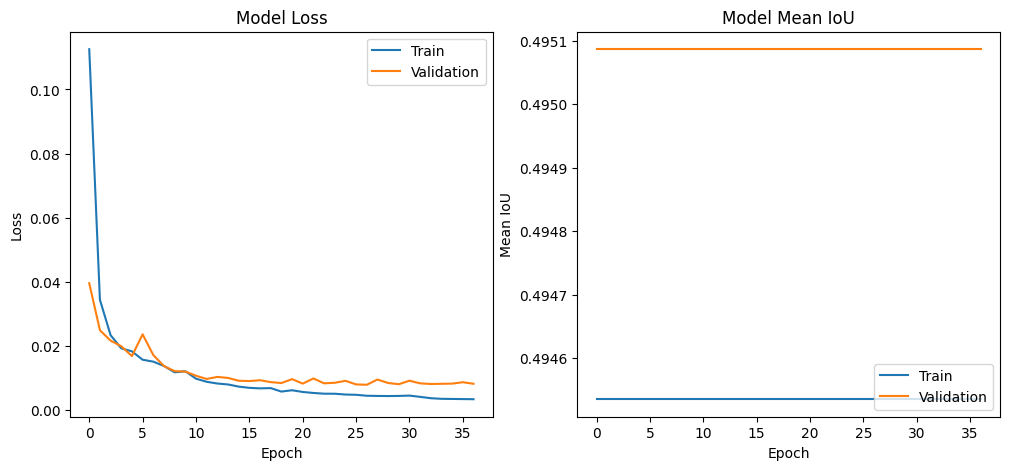

Displaying predictions on validation data...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


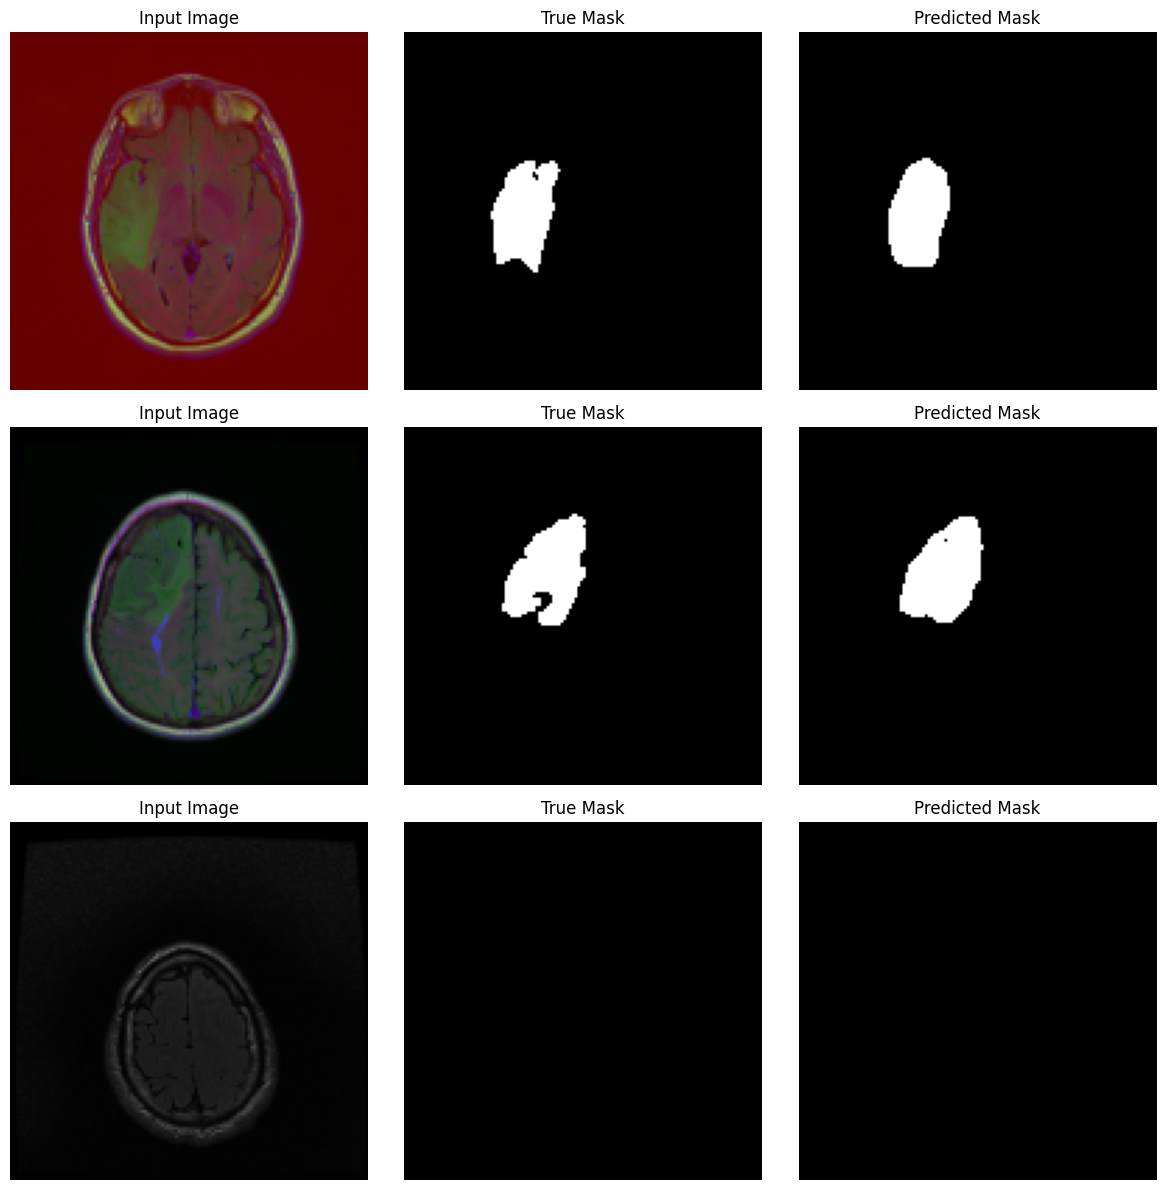

In [23]:
# --- Plot Training History ---
def plot_history(history):
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    # Plot training & validation Mean IoU values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('Model Mean IoU')
    plt.ylabel('Mean IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.show()

plot_history(history)

# --- Visualize Predictions ---
def display_predictions(dataset, num_samples=3):
    for image, true_mask in dataset.take(1):
        predictions = model.predict(image)
        # Binarize the prediction
        predicted_mask = (predictions > 0.5).astype(np.uint8)
        
        plt.figure(figsize=(12, num_samples * 4))
        for i in range(num_samples):
            # Original Image
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.title("Input Image")
            plt.imshow(image[i])
            plt.axis('off')

            # True Mask
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.title("True Mask")
            plt.imshow(true_mask[i], cmap='gray')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.title("Predicted Mask")
            plt.imshow(predicted_mask[i], cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

print("Displaying predictions on validation data...")
display_predictions(val_dataset)


Loading the best model from best_model.h5...

Evaluating model performance on the test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 877ms/step - loss: 0.0097 - mean_iou: 0.4939

Test Loss: 0.0098
Test Mean IoU: 0.4934

Displaying predictions on the test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


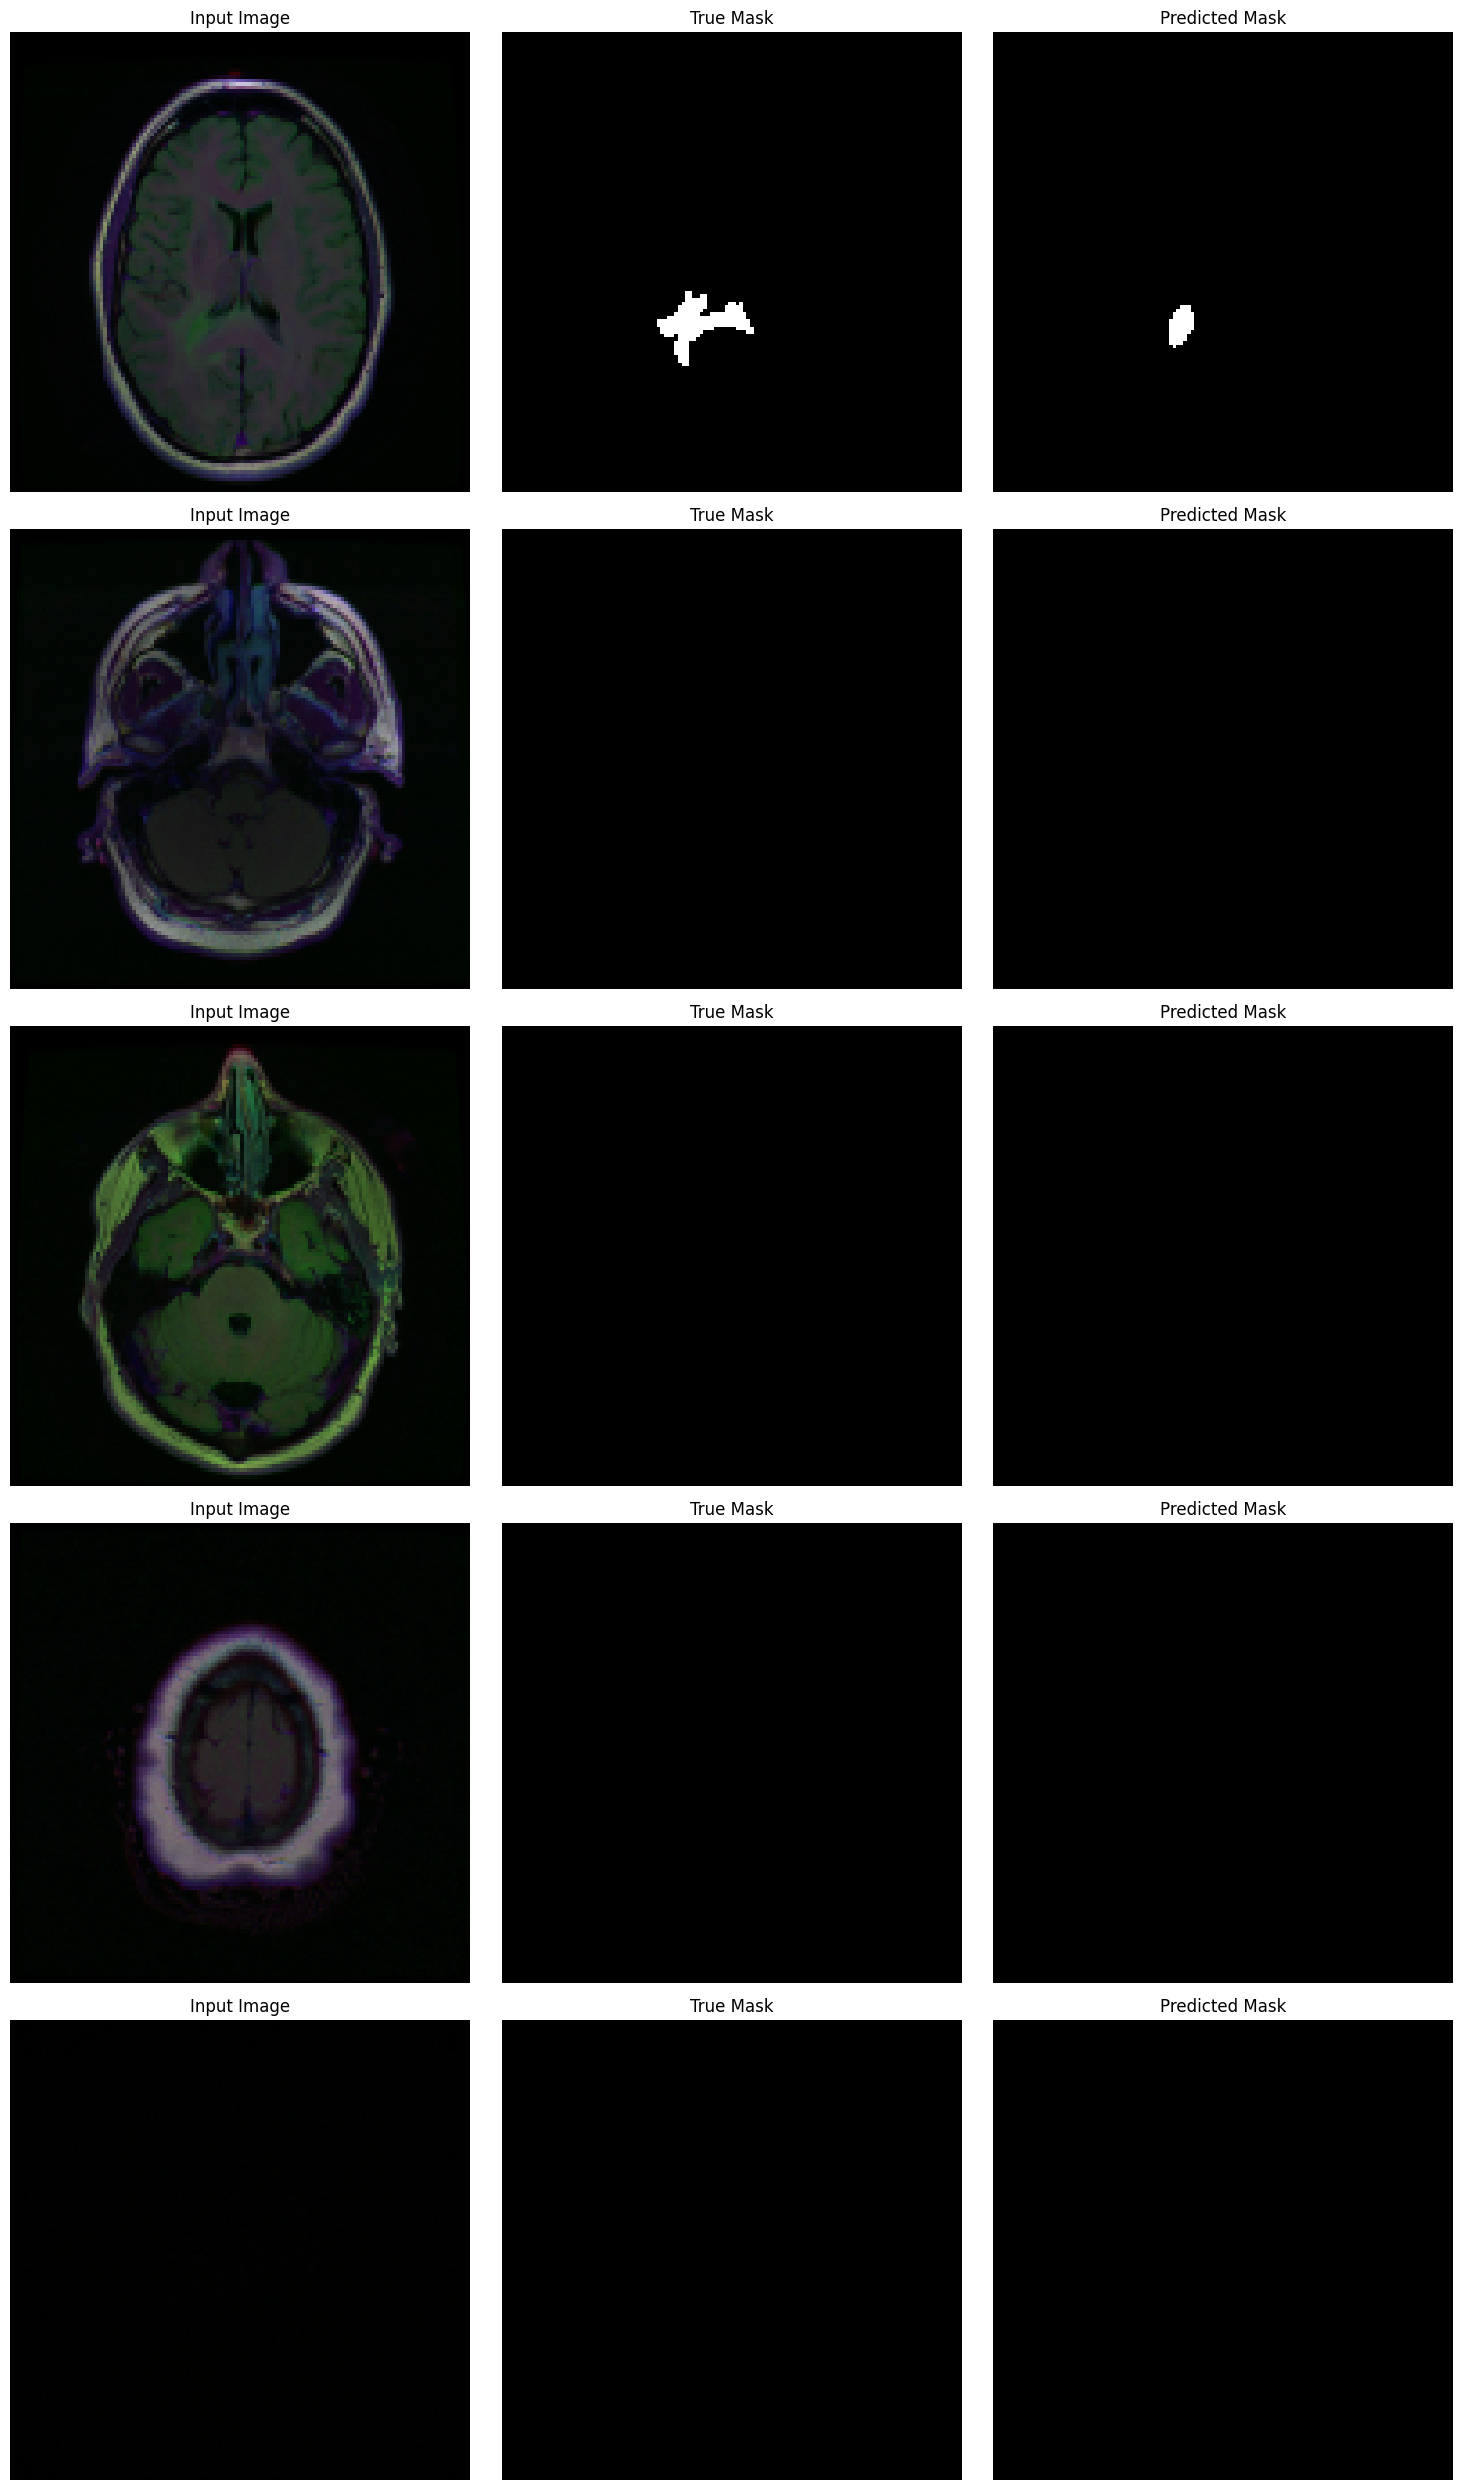

In [24]:
# --- Load the best model from the .h5 file ---
# We use load_model from tensorflow.keras.models
from tensorflow.keras.models import load_model

# The EarlyStopping callback with restore_best_weights=True already restored the 
# best weights to the 'model' object in memory. However, to demonstrate loading 
# from the file, we will do it explicitly.
print("\nLoading the best model from best_model.h5...")
best_model = load_model('best_model.h5')

# --- Evaluate the model on the unseen test data ---
print("\nEvaluating model performance on the test set...")
test_loss, test_iou = best_model.evaluate(test_dataset)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Mean IoU: {test_iou:.4f}")


# --- Visualize predictions on the test set ---
# The display_predictions function from the original code can be reused
def display_predictions(dataset, model, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))
    for i, (image, true_mask) in enumerate(dataset.unbatch().take(num_samples)):
        # Predict on a single image (requires adding a batch dimension)
        image_batch = tf.expand_dims(image, axis=0)
        predictions = model.predict(image_batch)
        predicted_mask = (predictions[0] > 0.5).astype(np.uint8)
        
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.title("Input Image")
        plt.imshow(image)
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.title("True Mask")
        plt.imshow(tf.squeeze(true_mask), cmap='gray')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.title("Predicted Mask")
        plt.imshow(tf.squeeze(predicted_mask), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nDisplaying predictions on the test data...")
display_predictions(test_dataset, best_model)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

print("Loading the best model from best_model.h5...")
# Load the saved model
best_model = load_model('best_model.h5')

# Re-compile the model to include pixel accuracy for evaluation
# The learned weights are not affected by this step.
print("Re-compiling model to add the accuracy metric for evaluation...")
best_model.compile(
    loss='binary_crossentropy',
    metrics=[
        MeanIoU(num_classes=2, name='mean_iou'),
        BinaryAccuracy(name='pixel_accuracy') # Add pixel accuracy here
    ]
)

# Evaluate the model on the test dataset
print("\nEvaluating model on the test set...")
results = best_model.evaluate(test_dataset)

# The 'results' list will contain the loss and all compiled metrics
test_loss = results[0]
test_iou = results[1]
test_pixel_accuracy = results[2]

print("\n--- Test Set Performance ---")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Mean IoU: {test_iou:.4f}")
print(f"Test Pixel Accuracy: {test_pixel_accuracy:.4f} (or {test_pixel_accuracy*100:.2f}%)")

Loading the best model from best_model.h5...
Re-compiling model to add the accuracy metric for evaluation...

Evaluating model on the test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 851ms/step - loss: 0.0097 - mean_iou: 0.4939 - pixel_accuracy: 0.9966

--- Test Set Performance ---
Test Loss: 0.0098
Test Mean IoU: 0.4934
Test Pixel Accuracy: 0.9966 (or 99.66%)
